# EDA

Resumo para ansiosos:

- <b>Estrutura dos Dados:</b> Consistem em arquivos de áudio (.wav) e metadados (.xlsx)

- <b>Metadados:</b> A análise dos arquivos .xlsx mostrou as características demográficas dos participantes, como idade e sexo. Para o conjunto de treino, há 272 amostras com uma idade média de aproximadamente 63,5 anos. O conjunto de teste possui 67 amostras.

- <b>Dados de Áudio:</b> Usei uma função que extraiu características básicas dos áudios, como duração, energia e taxa de amostragem (sr). Notou-se que todos os áudios possuem uma taxa de amostragem de 8000 Hz, o que é ótimo para a consistência do modelo.

- <b>Variação da Duração:</b> Sua análise, especialmente os histogramas e boxplots, confirmou uma das suas principais dificuldades: os áudios têm durações variadas, tanto no conjunto de treino (média de 13,8s) quanto no de teste (média de 12,8s).

Como nem tudo são flores, vamos falar sobre os problemas, mas vale lembrar que não fui convidado para apontar problemas e sim propor soluções, então tentarei realizar algumas ações que considero ao alcance do meu nível de conhecimento para solucionar/minimizar.

<b>Problema 1:</b> Os áudios possuem durações diferentes

Pelo que andei me estudando sobre o assunto, modelos como CNNs esperam vetores de características de tamanho fixo para cada amostra.

Discutindo com a equipe pensamos em duas abordagens para resolver isso:

1-<b>Padronizar o Tamanho do Áudio (Padding/Truncating)</b>

Basta definir um comprimento fixo (em número de amostras). Áudios mais curtos são preenchidos com silêncio (zeros) no final (padding), e áudios mais longos são cortados (truncating). Então se definirmos um comprimento de 15 segundos (15 * 8000 = 120.000 amostras), um áudio de 12 segundos será preenchido com 3 segundos de silêncio, e um de 17 segundos terá os 2 últimos segundos descartados.

<b>!!!ALERTA DE PERDA DE INFORMAÇÕES GRAVE!!!</b>

2-<b>Extrair Features com Agregação Temporal (Feature Aggregation)</b>:

Em vez de usar o áudio bruto, basta extrair características (features) de pequenas janelas de tempo (frames) ao longo de todo o áudio. Depois, calcular estatísticas sobre essas características (média, desvio padrão, mínimo, máximo, etc.). O resultado é um vetor de features de tamanho fixo, independentemente da duração do áudio.
Para um áudio, podemos calcular os Coeficientes Cepstrais de Frequência Mel (MFCCs) para cada frame de 25ms. Em seguida, calcular a média e o desvio padrão de cada coeficiente ao longo de todos os frames e gerar um vetor de tamanho fixo.

<b>Problema 2:</b> Que diabo de feature contribui para o que buscamos?

As features fonéticas que o aplicativo captura são: Frequência Fundamental (F0), Jitter, Shimmer e HNR

São características acústicas específicas da produção de voz, frequentemente usadas para detectar patologias vocais.

- Frequência Fundamental (F0): A frequência mais baixa da vibração das cordas vocais, percebida como o "tom" da voz.
- Jitter: Mede a variação da frequência fundamental entre ciclos vibratórios consecutivos (instabilidade na frequência).
- Shimmer: Mede a variação da amplitude entre ciclos consecutivos (instabilidade na amplitude/volume).
- HNR (Harmonics-to-Noise Ratio): Relação harmônico-ruído, que quantifica a proporção de energia harmônica (voz) em relação à energia de ruído (sopro, aspereza).

Já temos conhecimento das bibliotecas <code>librosa</code>, da <code>tsfresh</code> (Valeu Rafael ;-;) e mavegando pelos confins da internet encontrei uma tal de <code>parselmouth</code> (Bruxaria das brabas). Depois podemos confirmar com algum mago do aúdio se ela vale algo

### Bibliotecas

In [266]:
import os
import re
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import librosa
import soundfile as sf
import librosa.display

start_time = time.time()

In [204]:
try:
    current_file = os.path.abspath(__file__)
    current_dir = os.path.dirname(current_file)
except NameError:
    current_dir = os.getcwd()
    
base_dir = os.path.dirname(current_dir)

output_dir = "./images"
os.makedirs(output_dir, exist_ok=True)

test_audio_path = os.path.join(base_dir, 'data', 'dataset_task1', 'test')
test_xlsx_path = os.path.join(base_dir, 'data', 'dataset_task1', 'test', 'test.xlsx')

training_audio_path = os.path.join(base_dir, 'data', 'dataset_task1', 'train')
training_xlsx_path = os.path.join(base_dir, 'data', 'dataset_task1', 'train', 'train.xlsx')

# Verificação dos caminhos
print(os.path.exists(test_xlsx_path))
print(os.path.exists(test_audio_path))
print(os.path.exists(training_xlsx_path))
print(os.path.exists(training_audio_path))

# Carregando DFs
xls_training_data = pd.ExcelFile(training_xlsx_path)
xls_test_data = pd.ExcelFile(test_xlsx_path)

df_training_task = pd.read_excel(xls_training_data, sheet_name='SAND - TRAINING set - Task 1')
df_training_baseline_task = pd.read_excel(xls_training_data, sheet_name='Training Baseline - Task 1')
df_validation_baseline_task = pd.read_excel(xls_training_data, sheet_name='Validation Baseline - Task 1')

df_test_task = pd.read_excel(xls_test_data, sheet_name='SAND - TESTING set - Task 1')

True
True
True
True


In [ ]:
def analyze_audio_files(audio_dir):
    print(f"Iniciando análise em: {audio_dir}")
    audio_data = []
    # O task_type é o nome do subdiretório imediato (e.g., phonationA, rhythmPA).
    # Se o subdir for o audio_dir, então não há task_type específico para esse nível.
    for subdir, _, files in os.walk(audio_dir):
        if os.path.normpath(subdir) == os.path.normpath(audio_dir):
            continue

        task_type = os.path.basename(subdir)
        print(f"Processando task_type: {task_type} em {subdir}")
        
        for file in files:
            if file.endswith(".wav"):
                filepath = os.path.join(subdir, file)
                try:
                    # sr=None para manter a taxa de amostragem original
                    y, sr = librosa.load(filepath, sr=None)
                    duration = librosa.get_duration(y=y, sr=sr)
                    # Potência
                    power = np.sum(y**2) / len(y)
                    # Energia
                    # energy = np.sum(y**2)
                    
                    audio_data.append({
                        "filepath": filepath,
                        "filename": file,
                        "task_type": task_type,
                        "duration": duration,
                        "power": power,
                        "sr": sr
                    })
                except Exception as e:
                    print(f"Erro ao processar {filepath}: {e}")
    return pd.DataFrame(audio_data)

### Conjunto de treino

#### XLSX

In [177]:
df_training_task.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272 entries, 0 to 271
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      272 non-null    object
 1   Age     272 non-null    int64 
 2   Sex     272 non-null    object
 3   Class   272 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 8.6+ KB


In [178]:
# Estatísticas Descritivas para Variáveis Numéricas
df_training_task.describe()

Age       Class
count  272.000000  272.000000
mean    63.514706    3.926471
std     11.277110    1.087550
min     23.000000    1.000000
25%     56.750000    3.000000
50%     64.500000    4.000000
75%     72.000000    5.000000
max     89.000000    5.000000

In [179]:
# Distribuição de Gênero
df_training_task['Sex'].value_counts()

Sex
M    153
F    119
Name: count, dtype: int64

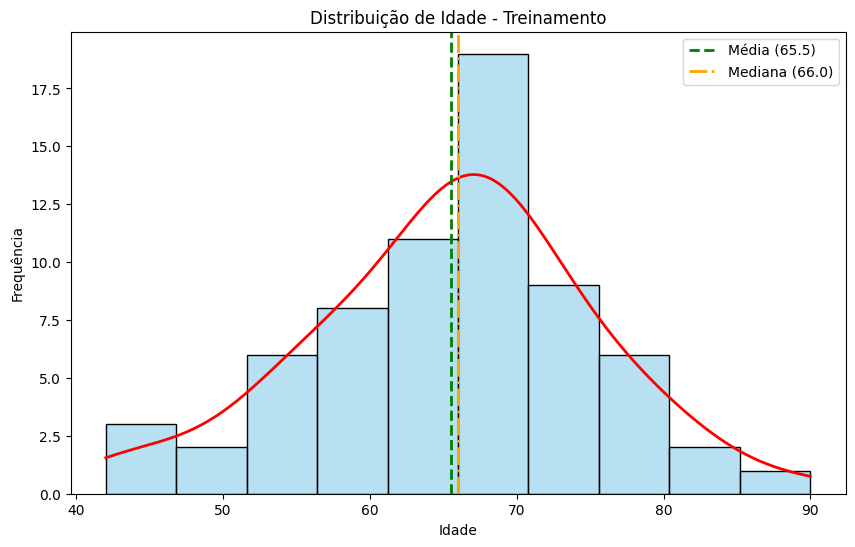

In [180]:
plt.figure(figsize=(10, 6))

sns.histplot(
    df_test_task['Age'],
    bins=10,
    color='skyblue',
    alpha=0.6,
    kde=True
)

for line in plt.gca().lines:
    line.set_color('red')
    line.set_linewidth(2)

media = df_test_task['Age'].mean()
mediana = df_test_task['Age'].median()
plt.axvline(media, color='green', linestyle='--', linewidth=2, label=f'Média ({media:.1f})')
plt.axvline(mediana, color='orange', linestyle='-.', linewidth=2, label=f'Mediana ({mediana:.1f})')

plt.title('Distribuição de Idade - Treinamento')
plt.xlabel('Idade')
plt.ylabel('Frequência')
plt.legend()
plt.show()

#### Audio

In [181]:
df_training_audio = analyze_audio_files(training_audio_path)
df_training_audio.head()

Iniciando análise em: c:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\train
Processando task_type: phonationA em c:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\train\phonationA
Processando task_type: phonationE em c:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\train\phonationE
Processando task_type: phonationI em c:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\train\phonationI
Processando task_type: phonationO em c:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\train\phonationO
Processando task_type: phonationU em c:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\train\phonationU
Processando task_type: rhythmKA em c:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\train\rhythmKA
Processando task_type: rhythmPA em c:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset

filepath              filename  \
0  c:\Users\joaov_zm1q2wh\Documents\projects\icas...  ID000_phonationA.wav   
1  c:\Users\joaov_zm1q2wh\Documents\projects\icas...  ID001_phonationA.wav   
2  c:\Users\joaov_zm1q2wh\Documents\projects\icas...  ID002_phonationA.wav   
3  c:\Users\joaov_zm1q2wh\Documents\projects\icas...  ID003_phonationA.wav   
4  c:\Users\joaov_zm1q2wh\Documents\projects\icas...  ID005_phonationA.wav   

    task_type  duration    energy    sr  
0  phonationA      9.88  0.016129  8000  
1  phonationA     17.48  0.010980  8000  
2  phonationA     23.72  0.023854  8000  
3  phonationA     12.00  0.009607  8000  
4  phonationA      6.92  0.005110  8000

In [182]:
df_training_audio['ID'] = df_training_audio['filename'].apply(
    lambda x: x.split('_')[0] if isinstance(x, str) else None
)
df_training_audio.head()

filepath              filename  \
0  c:\Users\joaov_zm1q2wh\Documents\projects\icas...  ID000_phonationA.wav   
1  c:\Users\joaov_zm1q2wh\Documents\projects\icas...  ID001_phonationA.wav   
2  c:\Users\joaov_zm1q2wh\Documents\projects\icas...  ID002_phonationA.wav   
3  c:\Users\joaov_zm1q2wh\Documents\projects\icas...  ID003_phonationA.wav   
4  c:\Users\joaov_zm1q2wh\Documents\projects\icas...  ID005_phonationA.wav   

    task_type  duration    energy    sr     ID  
0  phonationA      9.88  0.016129  8000  ID000  
1  phonationA     17.48  0.010980  8000  ID001  
2  phonationA     23.72  0.023854  8000  ID002  
3  phonationA     12.00  0.009607  8000  ID003  
4  phonationA      6.92  0.005110  8000  ID005

In [183]:
df_training_audio.describe()

duration       energy      sr
count  2176.000000  2176.000000  2176.0
mean     13.818564     0.007897  8000.0
std       7.355231     0.007234     0.0
min       0.720000     0.000005  8000.0
25%       8.480000     0.002779  8000.0
50%      12.400000     0.005428  8000.0
75%      17.930000     0.010637  8000.0
max      48.240000     0.046915  8000.0

In [184]:
# Distribuição de Duração por Tipo de Tarefa
df_training_audio.groupby('task_type')['duration'].describe()

count       mean       std   min   25%    50%        75%    max
task_type                                                                  
phonationA  272.0  13.673601  6.640975  3.00  8.66  12.74  17.690000  36.68
phonationE  272.0  12.694925  6.517372  2.12  8.20  11.82  16.014906  38.64
phonationI  272.0  13.424079  7.344660  2.08  7.95  12.00  17.610000  41.28
phonationO  272.0  13.505623  7.277069  1.48  8.20  12.22  17.700000  40.80
phonationU  272.0  13.496726  7.220216  1.72  8.12  12.58  17.660000  39.44
rhythmKA    272.0  13.123822  6.931443  0.72  8.39  11.78  17.120000  47.12
rhythmPA    272.0  15.538307  8.139902  2.32  9.35  13.88  20.800000  47.88
rhythmTA    272.0  15.091432  8.219127  2.48  9.39  13.44  20.400000  48.24

Text(0, 0.5, 'Contagem')

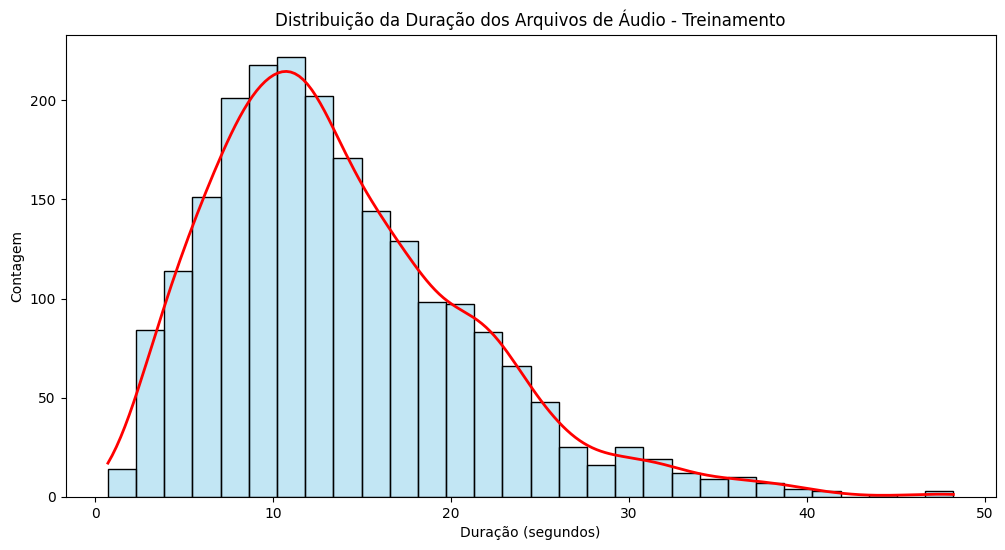

In [185]:
plt.figure(figsize=(12, 6))

sns.histplot(
    df_training_audio['duration'],
    kde=True,
    bins=30,
    color='skyblue'
)

for line in plt.gca().lines:
    line.set_color('red')
    line.set_linewidth(2)

plt.title('Distribuição da Duração dos Arquivos de Áudio - Treinamento')
plt.xlabel('Duração (segundos)')
plt.ylabel('Contagem')

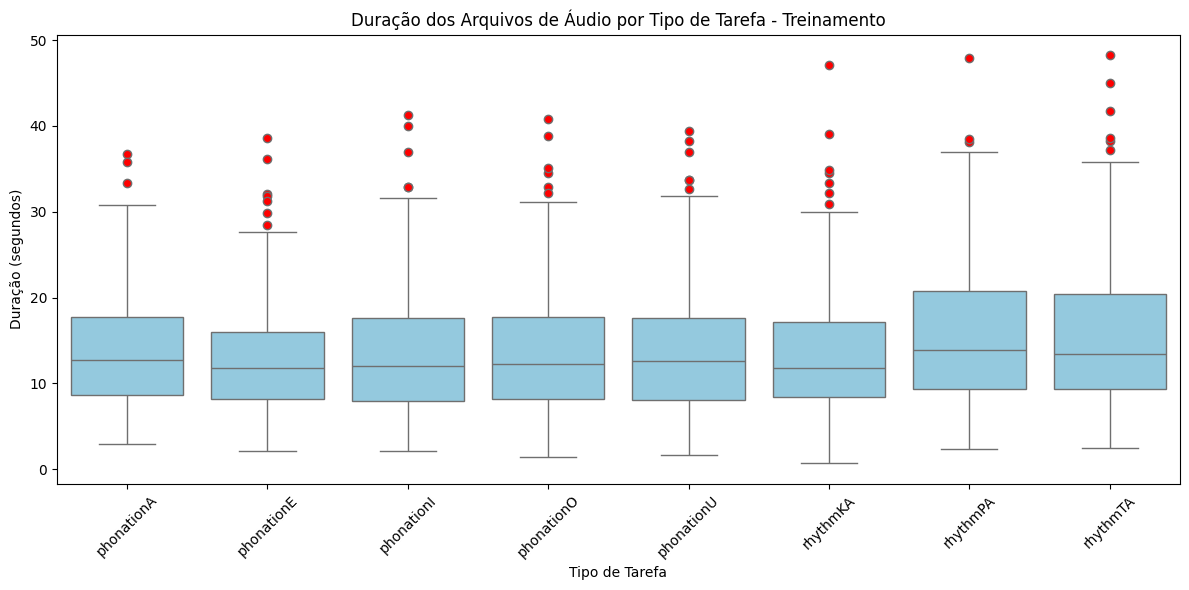

In [186]:
plt.figure(figsize=(12, 6))

flier_props = dict(marker='o', markerfacecolor='red', markersize=6, linestyle='none')

sns.boxplot(
    x="task_type",
    y="duration",
    data=df_training_audio,
    color='skyblue',
    flierprops=flier_props
)

plt.title("Duração dos Arquivos de Áudio por Tipo de Tarefa - Treinamento")
plt.xlabel("Tipo de Tarefa")
plt.ylabel("Duração (segundos)")
plt.xticks(rotation=45)
plt.tight_layout()

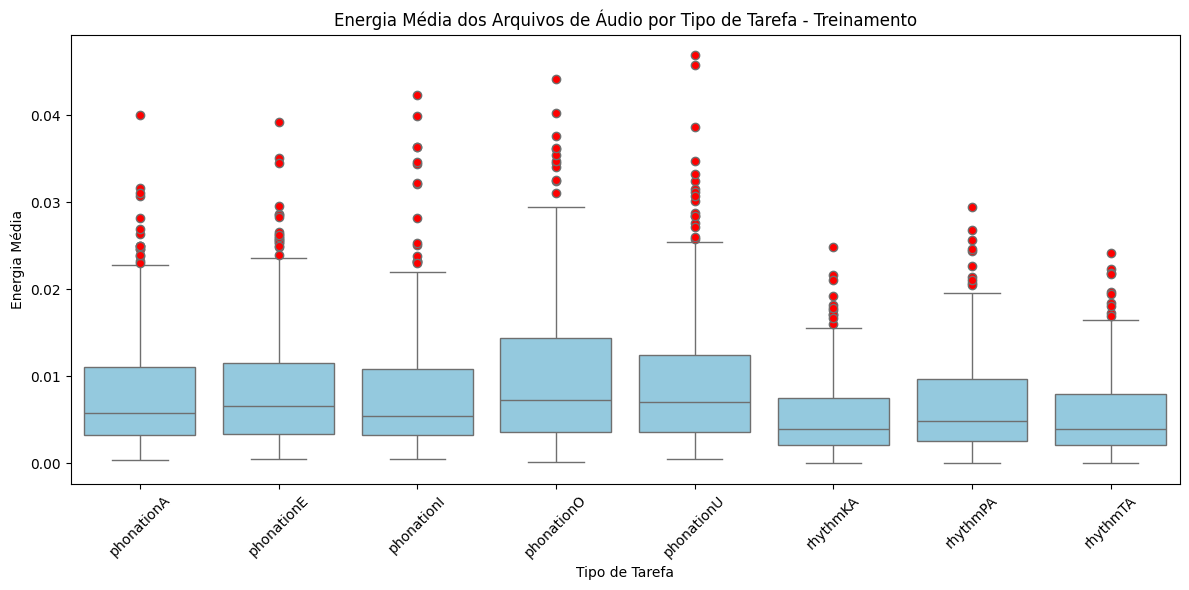

In [ ]:
plt.figure(figsize=(12, 6))

flier_props = dict(marker='o', markerfacecolor='red', markersize=6, linestyle='none')

sns.boxplot(
    x="task_type",
    y="power",
    data=df_training_audio,
    color='skyblue',
    flierprops=flier_props
)

plt.title("Power dos Arquivos de Áudio por Tipo de Tarefa - Treinamento")
plt.xlabel("Tipo de Tarefa")
plt.ylabel("Power")
plt.xticks(rotation=45)
plt.tight_layout()

### Conjunto de teste

#### XLSX

In [188]:
df_test_task.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      67 non-null     int64  
 1   Age     67 non-null     int64  
 2   Sex     67 non-null     object 
 3   Class   0 non-null      float64
dtypes: float64(1), int64(2), object(1)
memory usage: 2.2+ KB


In [189]:
# Estatísticas Descritivas para Variáveis Numéricas
df_test_task.describe()

ID        Age  Class
count   67.000000  67.000000    0.0
mean   165.029851  65.522388    NaN
std    103.273390   9.641071    NaN
min      4.000000  42.000000    NaN
25%     75.500000  59.500000    NaN
50%    161.000000  66.000000    NaN
75%    256.500000  71.500000    NaN
max    334.000000  90.000000    NaN

In [190]:
# Distribuição de Gênero
df_test_task['Sex'].value_counts()

Sex
M    40
F    27
Name: count, dtype: int64

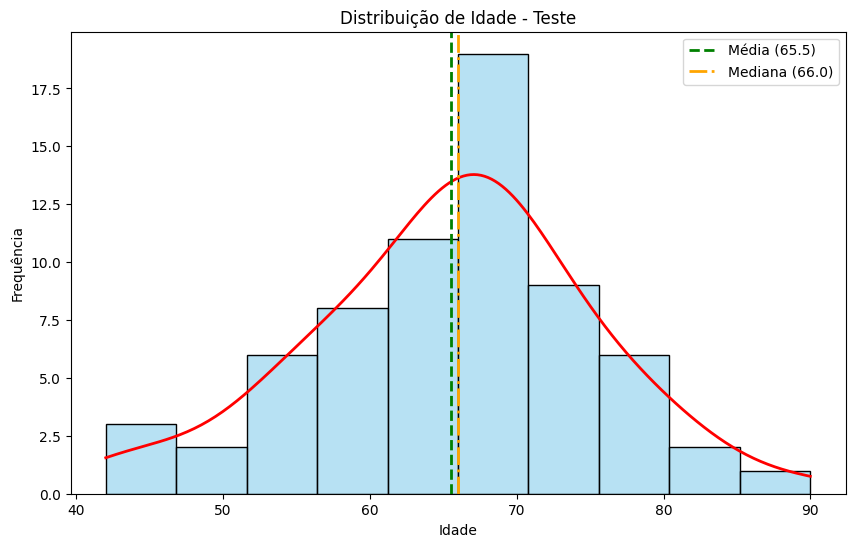

In [191]:
# Distribuição de Idade no Conjunto de Teste
plt.figure(figsize=(10, 6))

sns.histplot(
    df_test_task['Age'],
    bins=10,
    color='skyblue',
    alpha=0.6,
    kde=True
)

for line in plt.gca().lines:
    line.set_color('red')
    line.set_linewidth(2)

media = df_test_task['Age'].mean()
mediana = df_test_task['Age'].median()
plt.axvline(media, color='green', linestyle='--', linewidth=2, label=f'Média ({media:.1f})')
plt.axvline(mediana, color='orange', linestyle='-.', linewidth=2, label=f'Mediana ({mediana:.1f})')

plt.title('Distribuição de Idade - Teste')
plt.xlabel('Idade')
plt.ylabel('Frequência')
plt.legend()
plt.show()

#### Audio

In [192]:
df_test_audio = analyze_audio_files(test_audio_path)
df_test_audio.head()

Iniciando análise em: c:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\test
Processando task_type: phonationA em c:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\test\phonationA
Processando task_type: phonationE em c:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\test\phonationE
Processando task_type: phonationI em c:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\test\phonationI
Processando task_type: phonationO em c:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\test\phonationO
Processando task_type: phonationU em c:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\test\phonationU
Processando task_type: rhythmKA em c:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\test\rhythmKA
Processando task_type: rhythmPA em c:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\

filepath              filename  \
0  c:\Users\joaov_zm1q2wh\Documents\projects\icas...  ID004_phonationA.wav   
1  c:\Users\joaov_zm1q2wh\Documents\projects\icas...  ID011_phonationA.wav   
2  c:\Users\joaov_zm1q2wh\Documents\projects\icas...  ID014_phonationA.wav   
3  c:\Users\joaov_zm1q2wh\Documents\projects\icas...  ID019_phonationA.wav   
4  c:\Users\joaov_zm1q2wh\Documents\projects\icas...  ID020_phonationA.wav   

    task_type  duration    energy    sr  
0  phonationA     11.44  0.010252  8000  
1  phonationA      9.32  0.005053  8000  
2  phonationA     20.80  0.009374  8000  
3  phonationA      8.76  0.011543  8000  
4  phonationA     21.68  0.008217  8000

In [193]:
df_test_audio['ID'] = df_test_audio['filename'].apply(
    lambda x: x.split('_')[0] if isinstance(x, str) else None
)
df_test_audio.head()

filepath              filename  \
0  c:\Users\joaov_zm1q2wh\Documents\projects\icas...  ID004_phonationA.wav   
1  c:\Users\joaov_zm1q2wh\Documents\projects\icas...  ID011_phonationA.wav   
2  c:\Users\joaov_zm1q2wh\Documents\projects\icas...  ID014_phonationA.wav   
3  c:\Users\joaov_zm1q2wh\Documents\projects\icas...  ID019_phonationA.wav   
4  c:\Users\joaov_zm1q2wh\Documents\projects\icas...  ID020_phonationA.wav   

    task_type  duration    energy    sr     ID  
0  phonationA     11.44  0.010252  8000  ID004  
1  phonationA      9.32  0.005053  8000  ID011  
2  phonationA     20.80  0.009374  8000  ID014  
3  phonationA      8.76  0.011543  8000  ID019  
4  phonationA     21.68  0.008217  8000  ID020

In [194]:
df_test_audio.describe()

duration      energy      sr
count  536.000000  536.000000   536.0
mean    12.839478    0.011414  8000.0
std      6.580734    0.008824     0.0
min      4.240000    0.000543  8000.0
25%      7.670000    0.004674  8000.0
50%     11.060000    0.009240  8000.0
75%     16.400000    0.015571  8000.0
max     39.840000    0.052254  8000.0

Text(0, 0.5, 'Contagem')

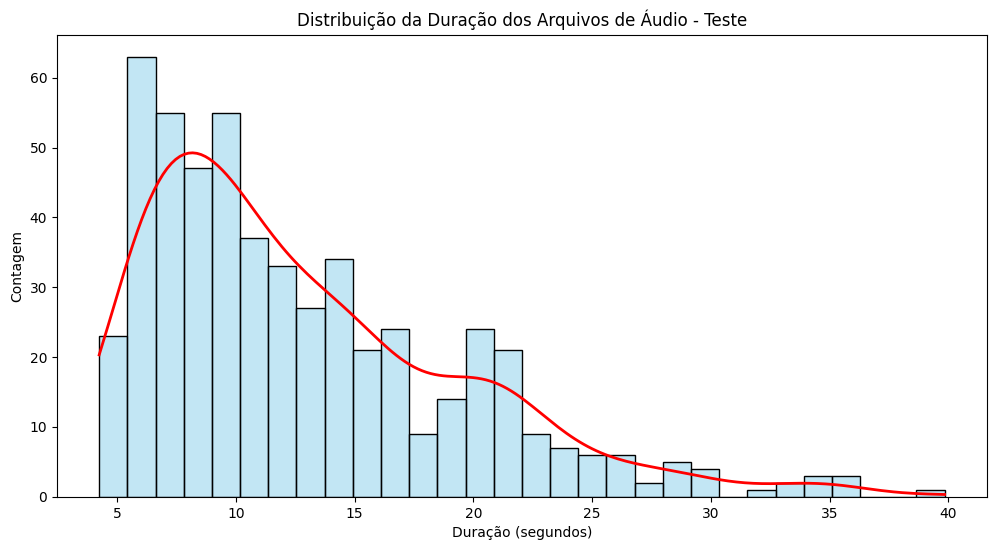

In [195]:
plt.figure(figsize=(12, 6))

sns.histplot(
    df_test_audio['duration'],
    kde=True,
    bins=30,
    color='skyblue'
)

for line in plt.gca().lines:
    line.set_color('red')
    line.set_linewidth(2)

plt.title('Distribuição da Duração dos Arquivos de Áudio - Teste')
plt.xlabel('Duração (segundos)')
plt.ylabel('Contagem')

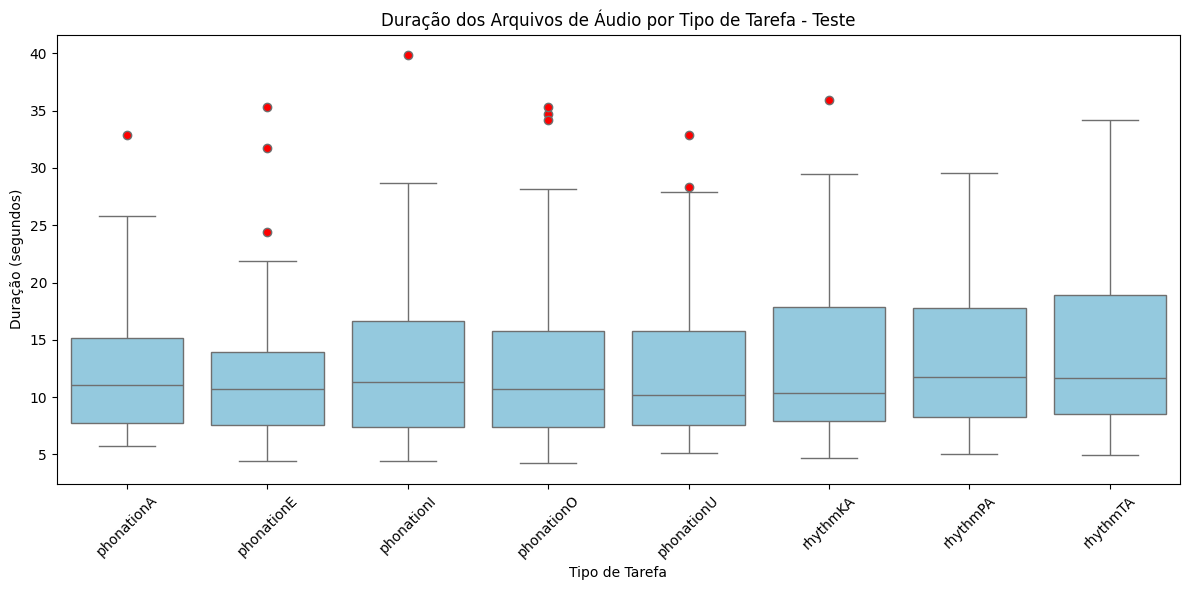

In [196]:
plt.figure(figsize=(12, 6))

flier_props = dict(marker='o', markerfacecolor='red', markersize=6, linestyle='none')

sns.boxplot(
    x="task_type",
    y="duration",
    data=df_test_audio,
    color='skyblue',
    flierprops=flier_props
)

plt.title("Duração dos Arquivos de Áudio por Tipo de Tarefa - Teste")
plt.xlabel("Tipo de Tarefa")
plt.ylabel("Duração (segundos)")
plt.xticks(rotation=45)
plt.tight_layout()

Tempo total de execução: 2.33 segundos


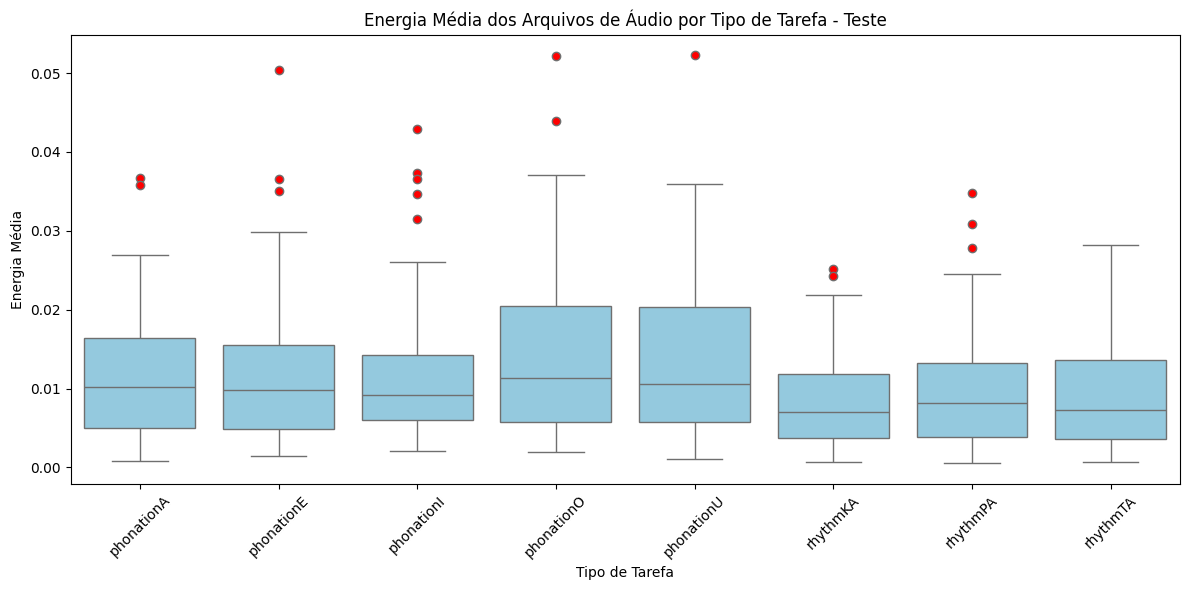

In [ ]:
plt.figure(figsize=(12, 6))

flier_props = dict(marker='o', markerfacecolor='red', markersize=6, linestyle='none')

sns.boxplot(
    x="task_type",
    y="power",
    data=df_test_audio,
    color='skyblue',
    flierprops=flier_props
)

plt.title("Power dos Arquivos de Áudio por Tipo de Tarefa - Teste")
plt.xlabel("Tipo de Tarefa")
plt.ylabel("Power")
plt.xticks(rotation=45)
plt.tight_layout()

###
end_time = time.time()
total_time = end_time - start_time
print(f"Tempo total de execução: {total_time:.2f} segundos")

Vamos atrás de uma amostra representativa desses dados, com isso eu quis dizer plotar os espectrogramas. Enquanto a forma de onda mostra a amplitude do som ao longo do tempo, o espectrograma nos dá uma "impressão digital" visual de como a energia do som se distribui pelas diferentes frequências ao longo do tempo.

Plotar todos os arquivos seria impraticável (Mas eu pratiquei...), no entanto, para avaliar, precisamos de um pouco de intuição para comparar amostras específicas e avaliar padrões.

O primeiro ponto foi olhar para diferenças entre classes (Saudável vs. Patológico). Ponto importantes para se observar:

- <b>Estabilidade dos harmônicos</b>

Uma voz saudável apresentará linhas horizontais nítidas, estáveis e bem definidas, que são os harmônicos da frequência fundamental ($F_0$). A linha mais baixa ($F_0$) deve ser relativamente reta. Já uma voz patológica pode apresentar harmônicos "trêmulos" ou "ondulados" (indicando Jitter e Shimmer), interrompidos, ou menos definidos.

- <b>Presença de Ruído</b>

Uma voz saudável terá pouco ruído entre as linhas dos harmônicos e esperasse que a energia esteja concentrada nessas linhas. Já na voz patológica, com soprosidade ou rouquidão mostrarão mais "sujeira" ou energia espalhada entre os harmônicos, fazendo com que o espectrograma pareça mais "borrado" ou "ruidoso".

- <b>Início e Fim da Fonação</b>

Aqui dá para avaliar como a produção da voz começa e termina. Uma voz saudável pode ter um início mais limpo, enquanto uma voz com alguma patologia pode mostrar instabilidade (quebras de frequência) no início ou no fim.

O segundo ponto são as diferenças entre Tipos de Tarefa

Comparar o espectrograma de diferentes tarefas para o mesmo indivíduo pode revelar muito sobre a capacidade de controle motor vocal.

Como são vogais sustentadas, esperamos ver um padrão de harmônicos estável ao longo do tempo. Podemos comparar as diferentes vogais e observar como a energia se concentra em diferentes bandas de frequência (os formantes), que é o que distingue acusticamente uma vogal da outra.

As tarefas chamadas de diadococinesia são projetadas para avaliar a agilidade articulatória. O espectrograma não será contínuo (O óbvio sendo dito) Veremos padrões que se repetem: um breve silêncio ou ruído de "explosão" para as consoantes ('P', 'T', 'K'), seguido pela vogal 'A' com seus harmônicos.

Podemos avaliar a regularidade do ritmo, a clareza das transições entre consoante e vogal, e se a qualidade da vogal se degrada ao longo das repetições.

- <b>Qualidade dos Dados e Anomalias</b>

Plotar alguns exemplos aleatórios ajuda a verificar a qualidade geral das suas amostras para procurar ruído de fundo. Se o áudio foi gravado muito alto, o sinal vai "saturar". No espectrograma, isso geralmente aparece como "faixas" verticais de ruído que se espalham por todas as frequências. Buscar se há longos períodos de silêncio no início ou no fim dos arquivos, o que será útil para pré-processar depois.

Observação importante:

- soundfile.read (sf.read) -> Retorna o sample rate original do arquivo.
- librosa.load -> Por padrão, resampleia o áudio para 22050 Hz, a menos que você passe sr=None.

Ex.:
```python
signal, sr = librosa.load(audio_file)           # sr = 22050 (default)
signal, sr = librosa.load(audio_file, sr=None)  # sr = 8000 (mantém original)
```

In [267]:
TICKS = np.array([31.25, 62.5, 125, 250, 500, 1000, 2000, 4000, 8000])
TICK_LABELS = np.array(["31.25", "62.5", "125", "250", "500", "1k", "2k", "4k", "8k"])

def plot_pair_spectrograms(file_path_1, file_path_2, fft_size=2048, hop_size=None, window_size=None):
    """
    Mostra dois espectrogramas lado a lado com barra de cor ajustada.
    """
    def compute_spectrogram(file_path):
        signal, fs = librosa.load(file_path, sr=None)
        if window_size is None:
            win = fft_size
        else:
            win = window_size
        if hop_size is None:
            hop = win // 4
        else:
            hop = hop_size
        stft = librosa.stft(signal, n_fft=fft_size, hop_length=hop, win_length=win, center=False)
        spectrogram_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
        return spectrogram_db, fs, hop

    # Gera espectrogramas
    spec1, fs1, hop1 = compute_spectrogram(file_path_1)
    spec2, fs2, hop2 = compute_spectrogram(file_path_2)

    # Cria figura e eixos
    fig, axes = plt.subplots(1, 2, figsize=(16, 4), sharey=True)

    # Primeiro espectrograma
    img1 = librosa.display.specshow(
        spec1, y_axis='log', x_axis='time', sr=fs1, hop_length=hop1, cmap='inferno', ax=axes[0]
    )
    axes[0].set_title(os.path.basename(file_path_1))
    axes[0].set_xlabel("Tempo [s]")
    axes[0].set_ylabel("Frequência [Hz]")
    axes[0].set_yticks(TICKS)
    axes[0].set_yticklabels(TICK_LABELS)

    # Segundo espectrograma
    img2 = librosa.display.specshow(
        spec2, y_axis='log', x_axis='time', sr=fs2, hop_length=hop2, cmap='inferno', ax=axes[1]
    )
    axes[1].set_title(os.path.basename(file_path_2))
    axes[1].set_xlabel("Tempo [s]")

    # Corrige a posição da barra de cores usando make_axes_locatable
    divider = make_axes_locatable(axes[1])
    cax = divider.append_axes("right", size="3%", pad=0.1)
    plt.colorbar(img2, cax=cax, format="%+2.0f dB")

    plt.tight_layout()
    plt.show()

Faixa de 60-70 Masculina

Exemplo 1:
- ID316,60,M,1
- ID289,61,M,5

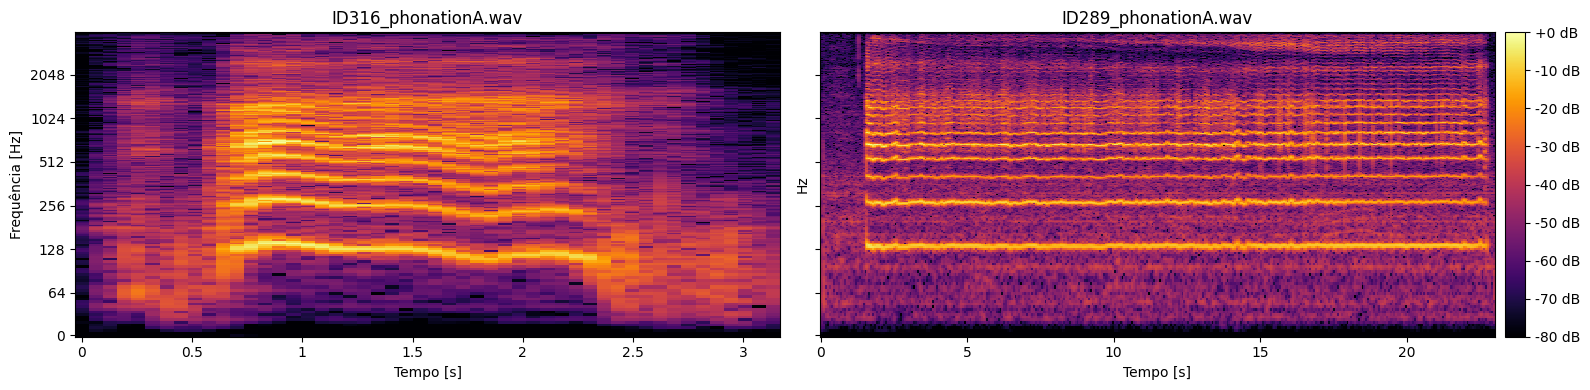

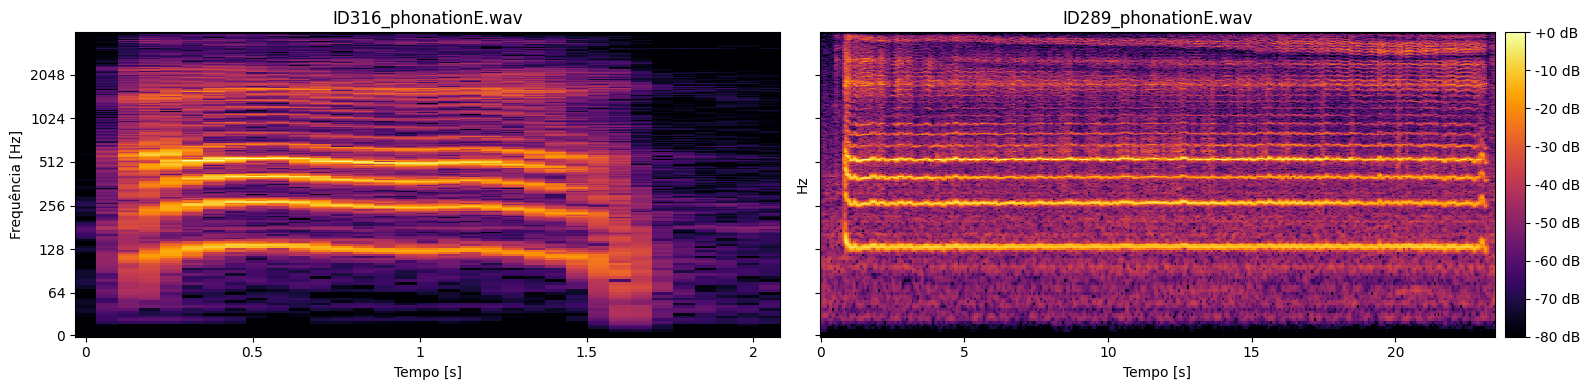

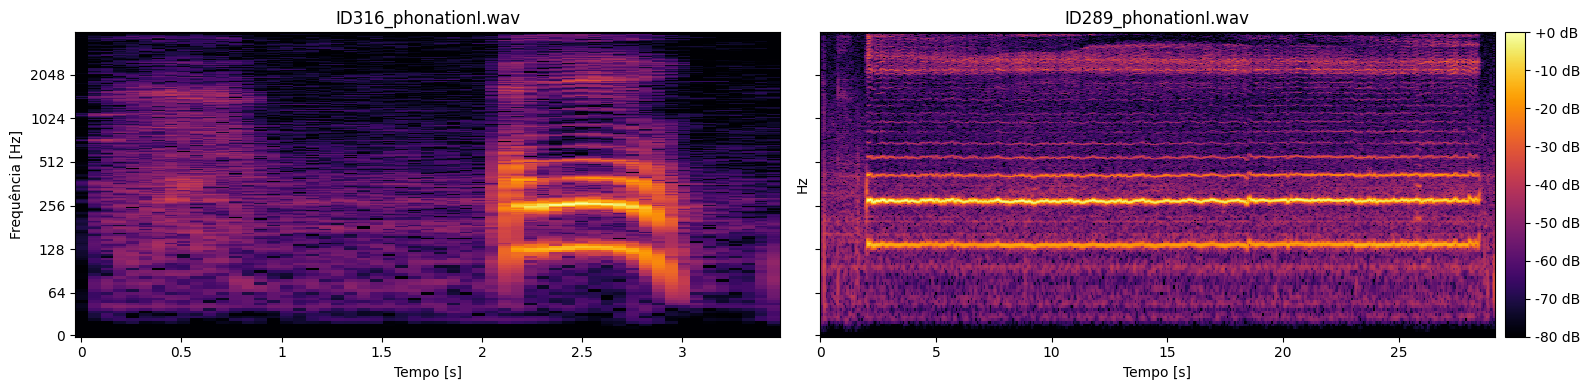

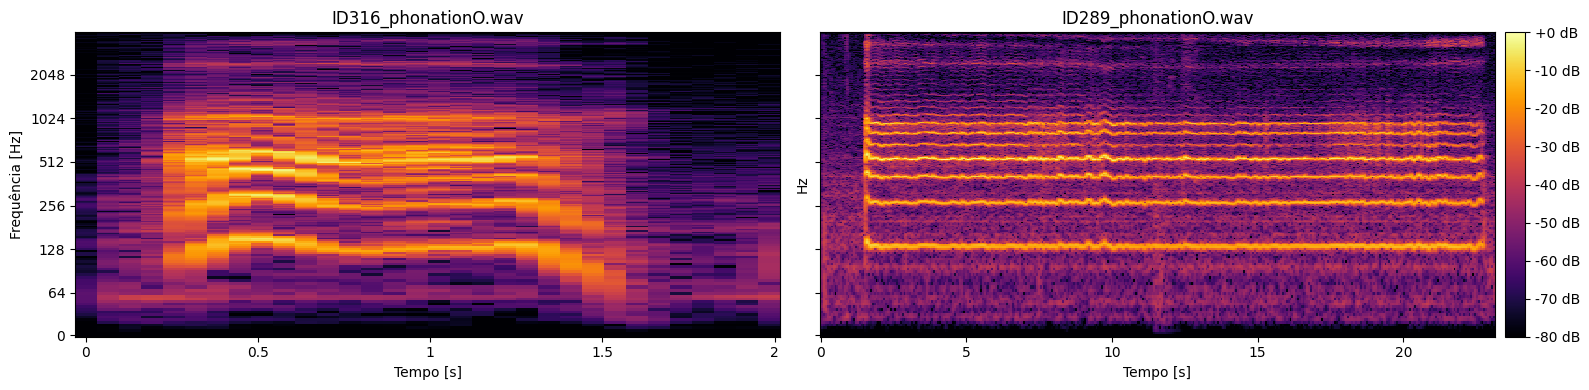

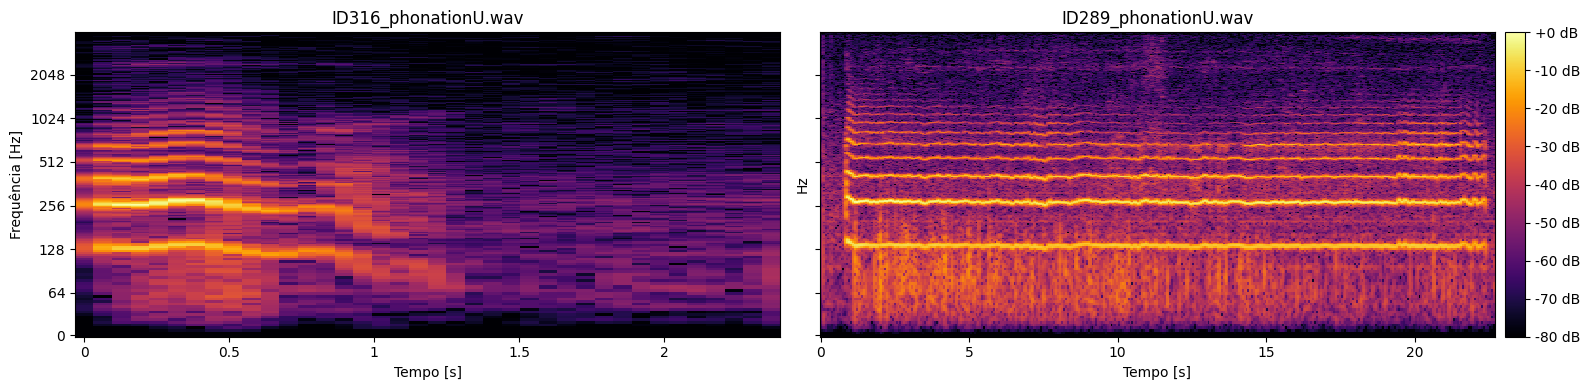

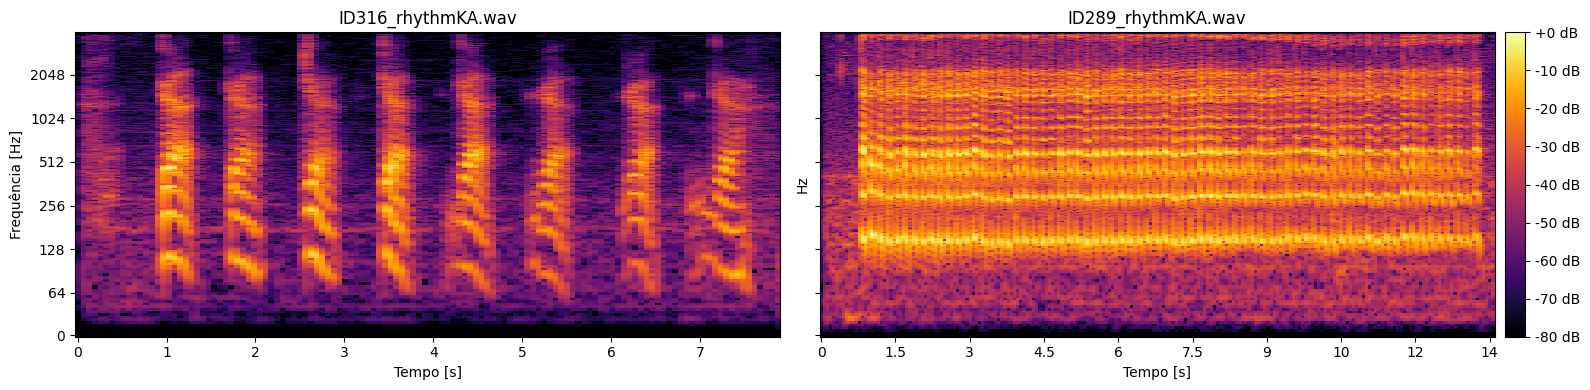

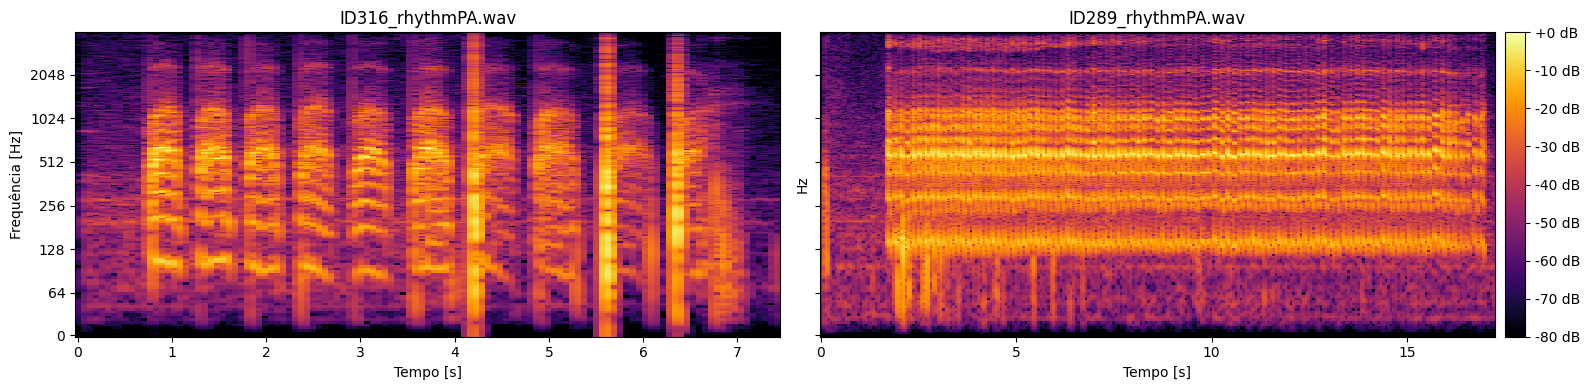

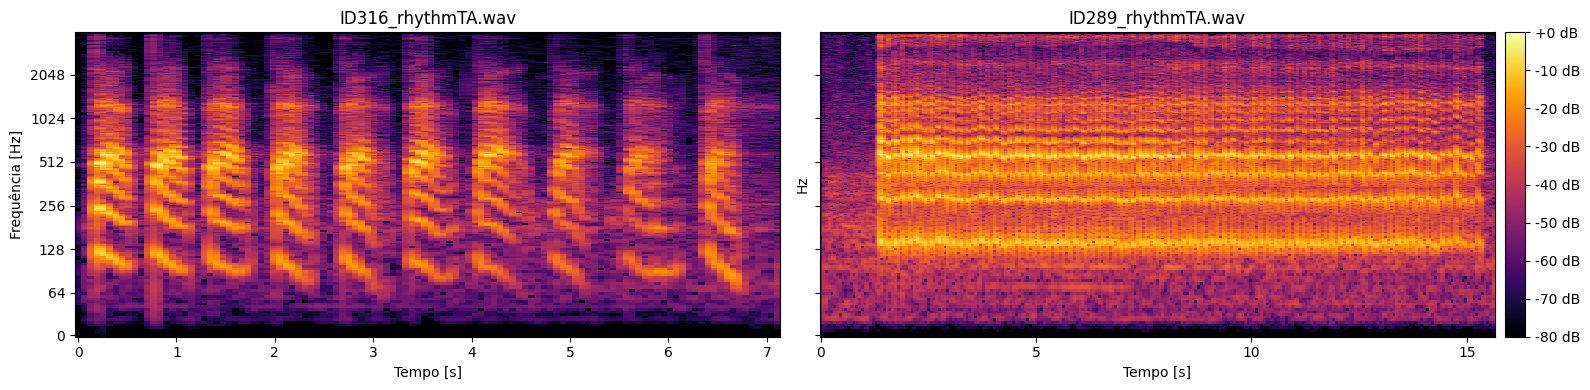

In [ ]:
plot_pair_spectrograms(
    r"C:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\train\phonationA\ID316_phonationA.wav",
    r"C:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\train\phonationA\ID289_phonationA.wav"
)

plot_pair_spectrograms(
    r"C:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\train\phonationE\ID316_phonationE.wav",
    r"C:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\train\phonationE\ID289_phonationE.wav"
    )

plot_pair_spectrograms(
    r"C:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\train\phonationI\ID316_phonationI.wav",
    r"C:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\train\phonationI\ID289_phonationI.wav"
    )

plot_pair_spectrograms(
    r"C:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\train\phonationO\ID316_phonationO.wav",
    r"C:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\train\phonationO\ID289_phonationO.wav"
    )

plot_pair_spectrograms(
    r"C:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\train\phonationU\ID316_phonationU.wav",
    r"C:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\train\phonationU\ID289_phonationU.wav"
    )

plot_pair_spectrograms(
    r"C:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\train\rhythmKA\ID316_rhythmKA.wav",
    r"C:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\train\rhythmKA\ID289_rhythmKA.wav"
    )

plot_pair_spectrograms(
    r"C:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\train\rhythmPA\ID316_rhythmPA.wav",
    r"C:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\train\rhythmPA\ID289_rhythmPA.wav"
    )

plot_pair_spectrograms(
    r"C:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\train\rhythmTA\ID316_rhythmTA.wav",
    r"C:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\train\rhythmTA\ID289_rhythmTA.wav"
    )

Faixa de 60-70 Feminina

Exemplo 2:
- ID138,60,F,1
- ID318,60,F,5

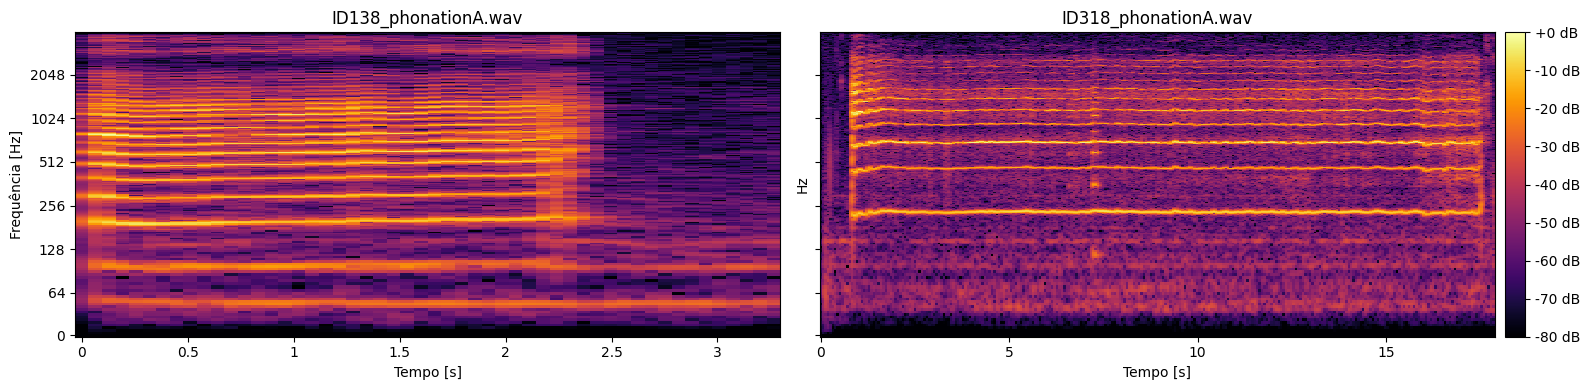

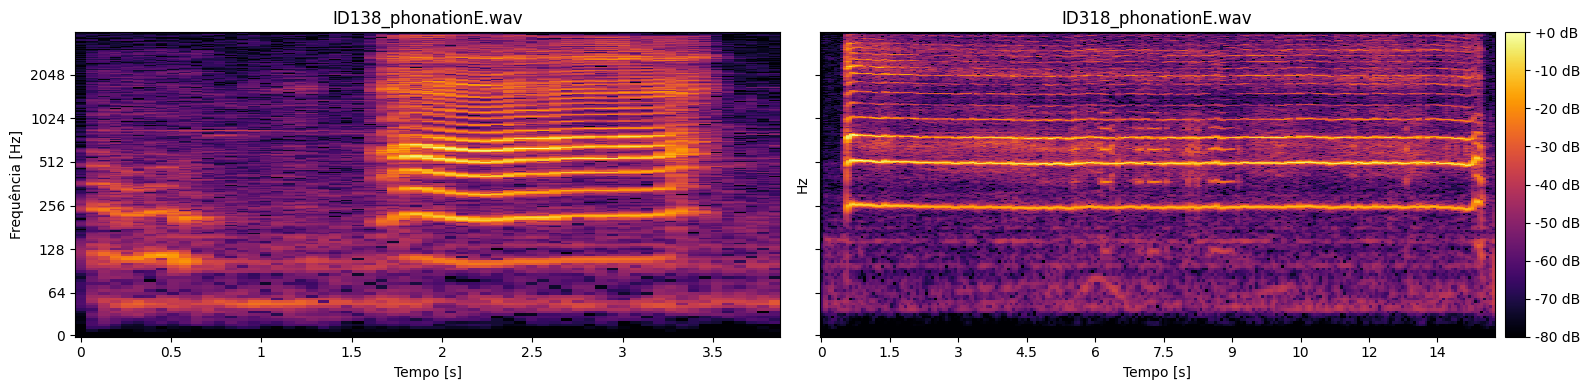

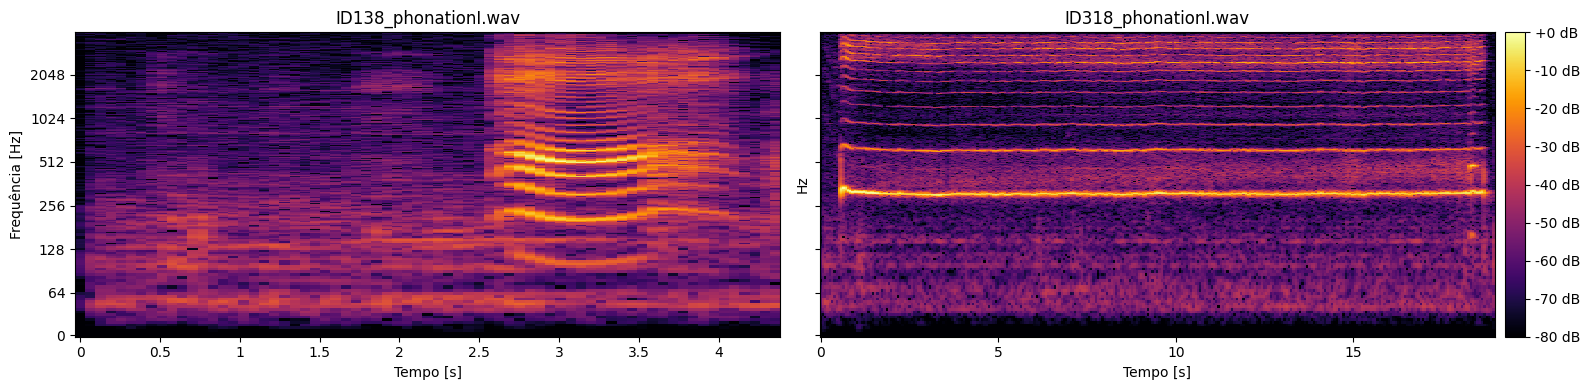

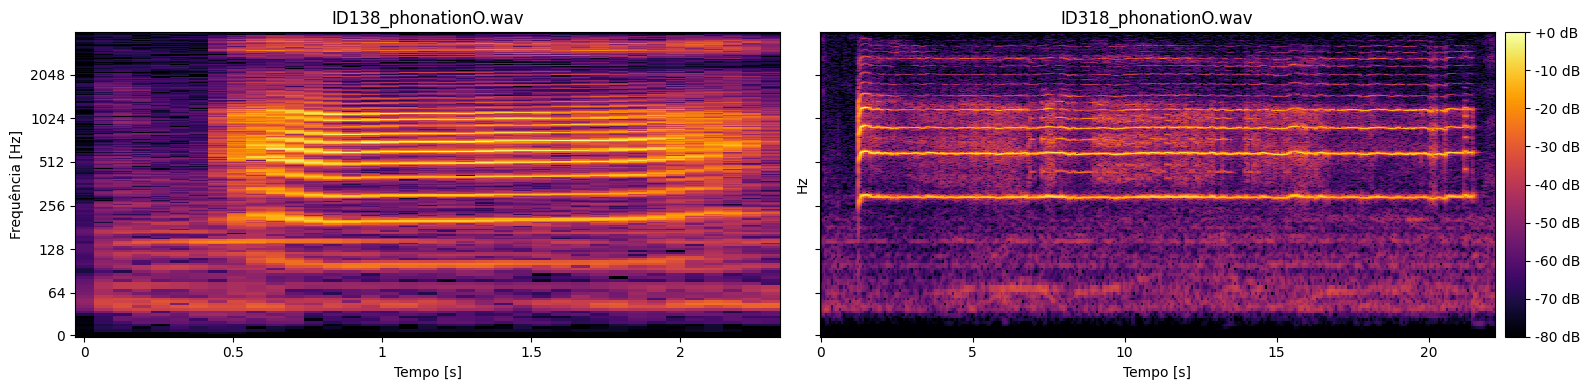

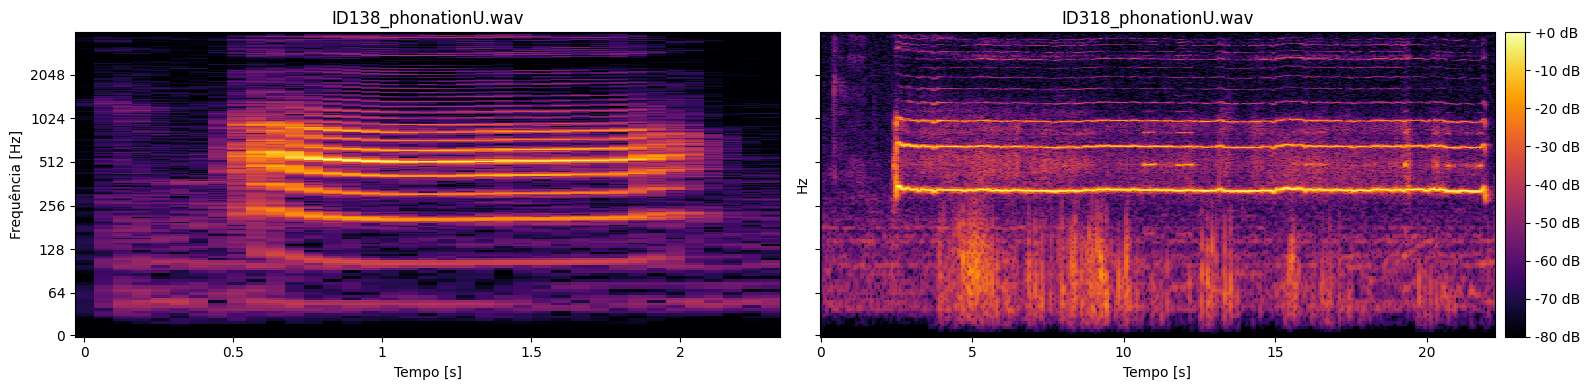

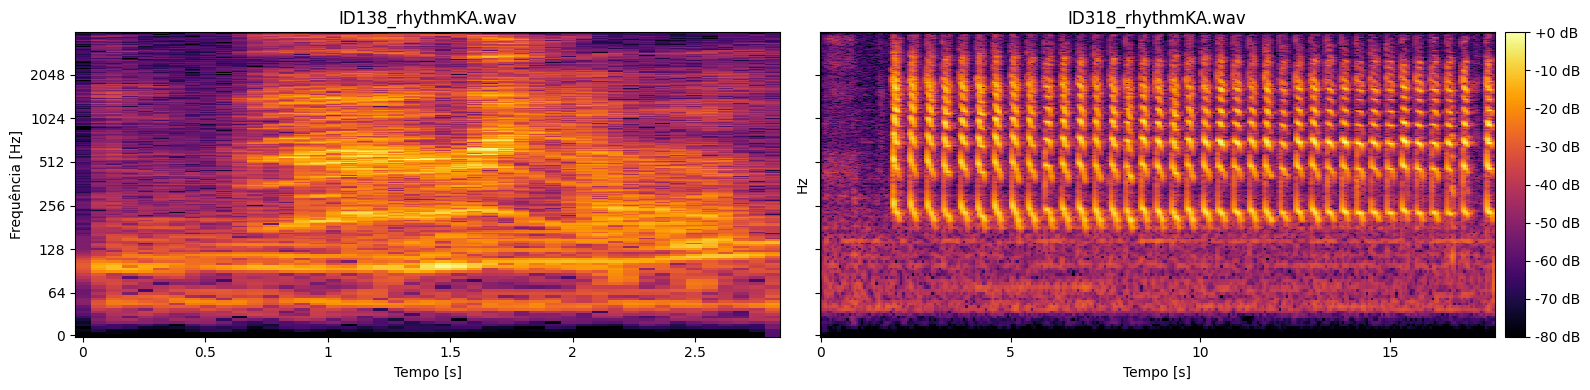

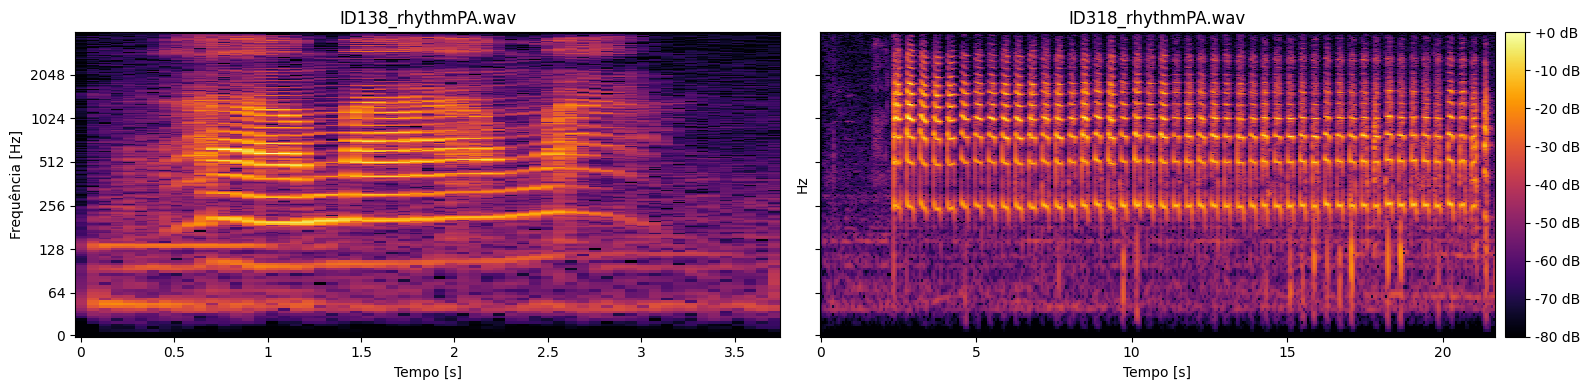

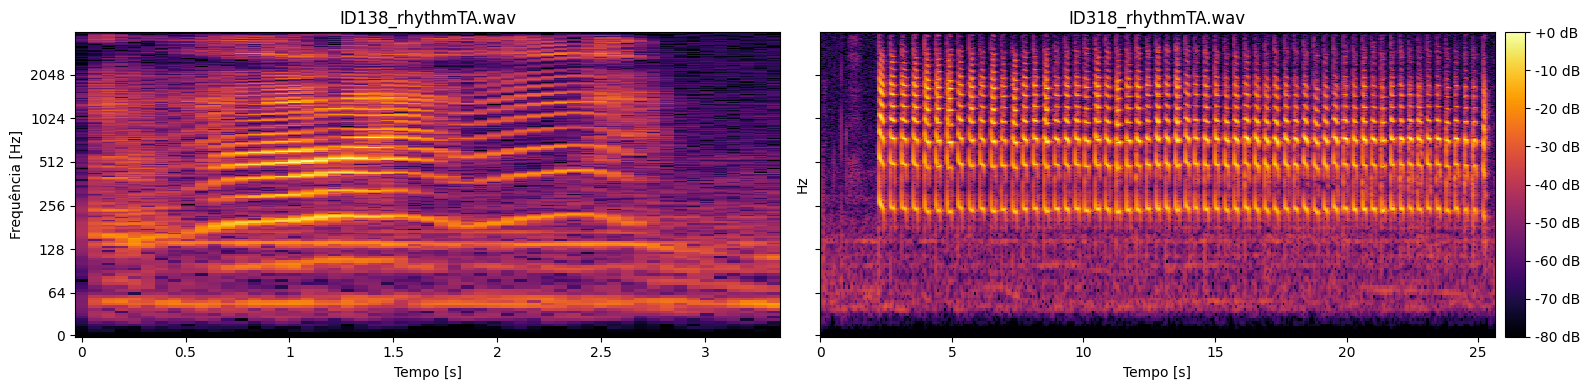

In [269]:
plot_pair_spectrograms(
    r"C:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\train\phonationA\ID138_phonationA.wav",
    r"C:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\train\phonationA\ID318_phonationA.wav"
)

plot_pair_spectrograms(
    r"C:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\train\phonationE\ID138_phonationE.wav",
    r"C:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\train\phonationE\ID318_phonationE.wav"
    )

plot_pair_spectrograms(
    r"C:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\train\phonationI\ID138_phonationI.wav",
    r"C:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\train\phonationI\ID318_phonationI.wav"
    )

plot_pair_spectrograms(
    r"C:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\train\phonationO\ID138_phonationO.wav",
    r"C:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\train\phonationO\ID318_phonationO.wav"
    )

plot_pair_spectrograms(
    r"C:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\train\phonationU\ID138_phonationU.wav",
    r"C:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\train\phonationU\ID318_phonationU.wav"
    )

plot_pair_spectrograms(
    r"C:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\train\rhythmKA\ID138_rhythmKA.wav",
    r"C:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\train\rhythmKA\ID318_rhythmKA.wav"
    )

plot_pair_spectrograms(
    r"C:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\train\rhythmPA\ID138_rhythmPA.wav",
    r"C:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\train\rhythmPA\ID318_rhythmPA.wav"
    )

plot_pair_spectrograms(
    r"C:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\train\rhythmTA\ID138_rhythmTA.wav",
    r"C:\Users\joaov_zm1q2wh\Documents\projects\icassp_challenge\data\dataset_task1\train\rhythmTA\ID318_rhythmTA.wav"
    )